In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import astropy.constants as cte
import astropy.units as un
import astropy.cosmology
from astropy.cosmology import Planck15 as cosmo
import emcee
import scipy.optimize as op
import corner
import scipy

In [2]:
c=cte.c
c_um=c.to("um/s")
c_mm=c.to("mm/s")
Msun=cte.M_sun

In [3]:
file = open("/Users/mariajesusfloresmoraga/Desktop/DSFG/SPT.csv")
csvreader = csv.reader(file)
header = []
header = next(csvreader)

rows = []
for row in csvreader:
        rows.append(row)

ID= []

z=[]

S3=[]
errS3=[]

S2=[]
errS2=[]

S1=[]
errS1=[]

S870=[]
errS870=[]

S500=[]
errS500=[]

S350=[]
errS350=[]

S250=[]
errS250=[]

S160=[]
errS160=[]

S100=[]
errS100=[]

for j in rows:   
    
    ID.append(j[0])
    z.append(float(j[1]))
    S3.append(float(j[2]))
    errS3.append(float(j[3]))
    S2.append(float(j[4]))
    errS2.append(float(j[5]))
    S1.append(float(j[6]))
    errS1.append(float(j[7]))
    S870.append(float(j[8]))
    errS870.append(float(j[9]))
    S500.append(float(j[10]))
    errS500.append(float(j[11]))
    S350.append(float(j[12]))
    errS350.append(float(j[13]))
    S250.append(float(j[14]))
    errS250.append(float(j[15]))
    S160.append(float(j[16]))
    errS160.append(float(j[17]))
    S100.append(float(j[18]))
    errS100.append(float(j[19]))
   

In [4]:
v__=np.array([870,500,350])*un.um
v_=(c_um/v__).to("Hz")
v=v_.value
l__=np.array([3.2,2,1.4])*un.mm
l_=(c_mm/l__).to("Hz")
l=l_.value
vf=np.concatenate((l,v))
print(vf)

[9.36851431e+10 1.49896229e+11 2.14137470e+11 3.44589032e+11
 5.99584916e+11 8.56549880e+11]


In [5]:
def tau(z,M_,d_,vf): 
    v0=353*un.GHz
    b=2
    M=Msun * 10** M_
    k0=0.15*(un.m**2/un.kg) 
    tau=k0*(vf/v0)**b *(z+1)**b * M/(np.pi*(d_/2)**2)
    return tau.to("")

In [6]:
def P(vf,T,z):
    h=cte.h
    K=cte.k_B
    A=2*h/(c**2)
    a=(h*vf*(1+z)/(K*T))
    B=vf**3/(np.e**(a.value) -1)
    P=(A*B).to("mJy")
    return P

In [62]:
def modelSv(z,T,M_,d_,vf):
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    M=Msun*(10**M_)
    d=d_
    O=np.pi*(d/2)**2 * (D**-2)
    S_=O*(1-np.e**-tau(z,M_,d_,vf))*P(vf,T,z)
    S=S_.to("mJy")
    return S

In [84]:
def A(z,Tc,M_,d_,vf): 
    v0=353*un.GHz
    b=2
    Tvariable=(np.linspace(Tc.value,500,10000)) *un.K
    integrales=[]
    for i in vf:
        integrales.append(scipy.integrate.trapz(modelSv(z,Tvariable,M_,d_,i)*(Tvariable)**-7,x=Tvariable))
    return integrales

In [184]:
def modelSobs(z,Tc,M_,d_,vf): #Como SPT no entrega Tc tomamos Tc= T-10
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    TCMB=2.725*un.K
    O=np.pi*(d_/2)**2 * (D**-2)
    integral=A(z,Tc,M_,d_,vf)
    h=cte.h
    K=cte.k_B
    model_=[]
    for j in range(len(vf)):
        M1=6 * Tc**6 * integral[j]
    
        M2=O * np.e**-tau(z,M_,d_,v0) * (2*h)/(c**2) * (vf[j]**3)/(np.e**(h*vf[j]/(K*TCMB))-1)
        model_.append((M1+M2).value)
    model=model_*un.mJy

    return model

SPT0002-52

In [158]:
z0=3
T0=66*un.K
M0_=np.log10(1.3*0.96*10**9) #U M
d0_=2.9*un.kpc
print(M0_)

9.096214585346406


In [159]:
#model_S_0=modelSv(z0,T0,M0_,d0_,vf*un.Hz)
model_PL_0=modelSobs(z0,T0-10*un.K,M0_,d0_,vf*un.Hz) 

[  0.91471065   4.00822276  12.93852217  53.68268814 165.40905578
 226.29842706] mJy


In [160]:
model_S_0-model_PL_0

<Quantity [   0.57907853,    2.78132199,    4.10236149,  -13.07737048,
            -84.34077792, -121.74330504] mJy>

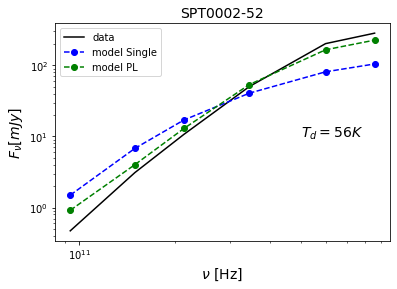

In [166]:
plt.plot(vf,frecs0T,"k",label="data")
plt.plot(vf,model_S_0,marker="o",ls="--",c="b",label="model Single")
plt.plot(vf,model_PL_0,marker="o",ls="--",c="g",label="model PL")
#plt.errorbar(v,frecs0[0],errf0[0],marker="o",markersize=8,markerfacecolor='red',c="k",label="ACT")
#plt.errorbar(l,frecs0[1],errf0[1],marker="o",markersize=8,markerfacecolor='blue',c="k",label="Herschel")
plt.xlabel(r"$\nu$ [Hz]",fontsize=14)
plt.ylabel(r"$F_{\nu} [mJy]$",fontsize=14)
plt.title("{}".format(ID[0]),fontsize=14)
plt.annotate(r"$T_{d}=56K$",(5*10**11,10),fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [177]:
def fit_bb(x, *p): #p not a list, x va en Hz
    #dejar una descripcion de los parametros que entran en la funcion entre comillas al comienzo
    """
    x : frecuencia *un.Hz ------> por alguna razon esto esta en Hz pero el v0 por ejemplo en GHz
    p = z T M d  ---------------> parametros a fitear   
    z : redshift (adimensional)
    T : temperatura cut-off en Kelvin pero sin usar unidades
    M : log(mu M/M_sun) (adimensional)
    d : distance *en kpc pero sin usar unidades
    
    return: modelo en mJy pero sin unidades
    """
    #queda definido dentro el valor de b y v0 que no se cambian nunca
    b = 2.0
    v0 = 353*un.GHz

    return modelSobs(p[0],p[1]*un.K,p[2],p[3]*un.kpc,x)

In [167]:
def lnlike(theta,x,y,yerr):
    lnf,z,T,M,d = theta
    x = x*un.Hz
    modelSobs = fit_bb(x,z,T,M,d).value
    inv_sigma2 = 1.0 / (yerr**2 + (modelSobs)**2 * np.exp(2*lnf))
    return -0.5 * np.sum((y-(modelSobs))**2*inv_sigma2 - np.log(inv_sigma2))

In [168]:
def lnprior(theta):
    lnf,z,T,M,d = theta
    if lnf<-1 and T>0 and z>0 and M>0 and d>0:
        return -1 * (T - 50)**2 / (2 * 10**2) #example gaussian
    return -np.inf

In [169]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not(np.isfinite(lp)):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [187]:
def ml(ID,z,T,M_,d_,frecsT,errfT): #recibe con unidades

    theta = [-1,z,T.value,M_,d_.value]
     

    n = lambda *args: -lnlike(*args)

    maxlike = op.minimize(n, theta, args=(vf,np.array(frecsT),np.array(errfT)))
    
    lnfM,zm,Tm,Mm,dm = maxlike["x"]
    
    plt.figure(figsize=(12,9))


    x0 = np.linspace(100,2000,100)*un.GHz
    x0 = x0.to("Hz")
    print(len(x0))
    
        
    pm = [zm,Tm,Mm,dm]

    y = fit_bb(x0,pm[0],pm[1],pm[2],pm[3])
    #print("y:",y)

    plt.plot(x0,y,label="MaxL")
    plt.errorbar(vf,np.array(frecsT),yerr=np.array(errfT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(zm,2),np.round(Tm,2),np.round(Mm,2),np.round(dm,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [180]:
def mcmc(ID,z,T,M_,d_,frecsT,errfT): #recibe con unidades, T=Tc =Td-10

    theta = [-1,z,T.value,M_,d_.value]
     

    n = lambda *args: -lnlike(*args)

    maxlike = op.minimize(n, theta, args=(vf,np.array(frecsT),np.array(errfT)))
    
    lnfM,zm,Tm,Mm,dm = maxlike["x"]
    
    plt.figure(figsize=(12,9))


    x0 = np.linspace(100,2000,100)*un.GHz
    x0 = x0.to("Hz")
    
        
    pm = [zm,Tm,Mm,dm]

    y = fit_bb(x0,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 5, 1000 # 6000 iteraciones
    pos = [maxlike["x"] + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)] #^5 por numero de dim
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,args=(vf,np.array(frecsT),np.array(errfT)),
                                threads=2)
    sampler.run_mcmc(pos, 100) #16 chains
    samples = sampler.chain[:, 90:, :].reshape((-1, ndim))
    
    fig = corner.corner(samples,
                    labels=["ln","z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    truths=[lnfM,zm,Tm,Mm,dm])

In [191]:
z_ref=3
T_ref=40*un.K
M_ref= 10 #np.log10(6.749*2.02*10**9) # log10(Uprom*M/Msun) = log10(Uprom*Mprom*10**9)
d_ref=4*un.kpc

SPT0002-52

In [190]:
frecs0T=np.array([S3[0],S2[0],S1[0],S870[0],S500[0],S350[0]])
errf0T=np.array([errS3[0],errS2[0],errS1[0],errS870[0],errS500[0],errS350[0]])

In [106]:
frecs0=[[S3[0],S2[0],S1[0]],[S870[0],S500[0],S350[0]]]
errf0=[[errS3[0],errS2[0],errS1[0]],[errS870[0],errS500[0],errS350[0]]]

100


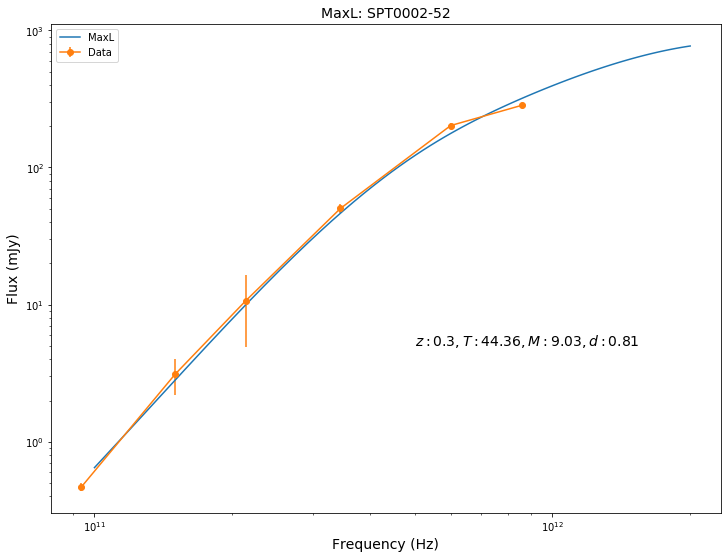

In [192]:
ml(ID[0],z_ref,T_ref,M_ref,d_ref,frecs0T,errf0T)

In [104]:
mcmc(ID[0],z_ref,T_ref,M_ref,d_ref,frecs0T,errf0T)

[  4.05725436  19.68194496  53.833078   139.78040834 264.58051282
 318.80065133] mJy
[  4.05725436  19.68194496  53.833078   139.78040834 264.58051282
 318.80065133] mJy
[  4.05725436  19.68194496  53.833078   139.78040834 264.58051282
 318.80065133] mJy
[  4.05725438  19.68194502  53.83307806 139.78040799 264.58051144
 318.80064896] mJy
[  4.05725436  19.68194496  53.83307802 139.7804084  264.580513
 318.8006516 ] mJy
[  4.05725448  19.68194541  53.8330788  139.78040875 264.58051283
 318.80065133] mJy
[  4.05725437  19.681945    53.83307822 139.78040929 264.5805148
 318.80065371] mJy
[  1.52934258   7.0236084   22.28387894  84.69199698 218.55359802
 268.64769113] mJy
[  1.52934258   7.0236084   22.28387894  84.69199698 218.55359802
 268.64769113] mJy
[  1.52934258   7.0236084   22.28387894  84.69199698 218.55359802
 268.64769113] mJy
[  1.52934259   7.02360843  22.28387902  84.69199705 218.55359706
 268.64768916] mJy
[  1.52934258   7.02360841  22.28387895  84.69199702 218.55359816
 2

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-16-2539da820b12>", line 5, in lnprob
    return lp + lnlike(theta, x, y, yerr)
  File "<ipython-input-103-358eccc7c4fb>", line 4, in lnlike
    modelSobs = fit_bb(x,z,T,M,d).value
  File "<ipython-input-13-f5437cf426b6>", line 17, in fit_bb
    return modelSobs(p[0],p[1]*un.K,p[2],p[3]*un.kpc,x)
  File "<ipython-input-100-5d13f714d6c2>", line 14, in modelSobs
    M2=O * np.e**-tau(z,M_,d_,v0) * (2*h)/(c**2) * (vf[j]**3)/(np.e**(h*vf[j]/(K*TCMB))-1)
  File "/opt/anaconda3/lib/python3.7/site-packages/astropy/constants/constant.py", line 56, in wrapper
    return meth(self, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py", line 947, in __mul__
    return super().__mul__(other)
  File "/opt/anaconda3/lib/python3.7/site-packages/astropy/constants/con

KeyboardInterrupt: 

<Figure size 864x648 with 0 Axes>